In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
%autoreload 2

import os
from dataclasses import asdict
import logging
from typing import *
import socket

import humanize
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf

from pathlib import Path
from progressbar import progressbar as pbar

In [22]:
filedir = "/home/users/jcasagrande/projects/tomo2seg/data/other-volumes/PA66GF30.biaxe"
filedirpath = Path(filedir)

data_filename = "video-crop.raw"
partial_mask_filename = "exterior-mask.raw"

In [23]:
data_filepath = filedirpath / data_filename
partial_mask_filepath = filedirpath / partial_mask_filename

In [24]:
dims = (734, 1554, 728)

In [25]:
voldata = file_utils.HST_read(
    str(data_filepath),  # it doesn't accept paths...

    autoparse_filename=False,  # the file names are not properly formatted
    data_type="uint8",
    dims=dims,
    verbose=False,

) 

In [14]:
volpartmask = file_utils.HST_read(
    str(partial_mask_filepath),  # it doesn't accept paths...

    autoparse_filename=False,  # the file names are not properly formatted
    data_type="uint8",
    dims=dims,
    verbose=False,

) 

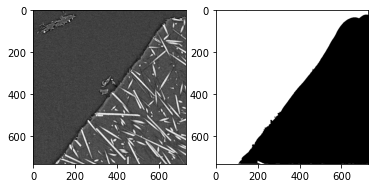

In [33]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(
    voldata[:, 1313, :],
    vmin=0, vmax=255, cmap='gray',
)

axs[1].imshow(
    volpartmask[:, 1313, :],
    vmin=0, vmax=2, cmap='gray',
)

In [35]:
np.unique(volpartmask, return_counts=True)

(array([0, 1, 2], dtype=uint8), array([765415251,    930697,  64037060]))

In [38]:
n_outside_on_y = (volpartmask == 2).sum(axis=(0, 2))

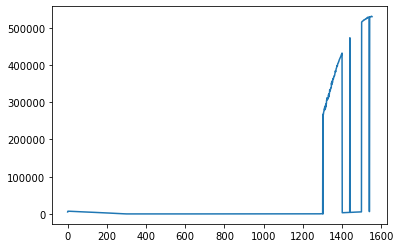

In [39]:
plt.plot(n_outside_on_y)

In [47]:
n_inside_on_y = (volpartmask == 1).sum(axis=(0, 2))

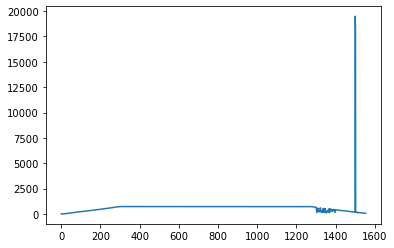

In [48]:
plt.plot(n_inside_on_y)

In [40]:
yslices = n_outside_on_y > 1e5

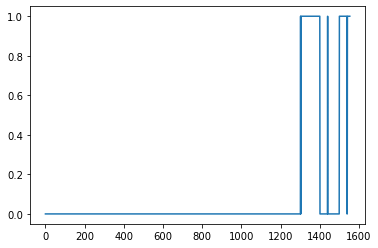

In [41]:
plt.plot(yslices)

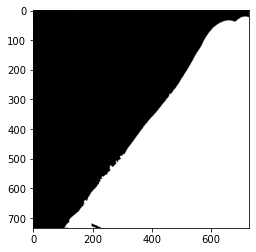

In [43]:
slc = volpartmask[:, 1313, :]

plt.imshow(
    slc != 2,
    vmin=0, vmax=1, cmap='gray',
)

In [44]:
volmask_complementary = volpartmask.copy()

In [68]:
volmask_complementary[:, yslices, :] = (volpartmask[:, yslices, :] != 2) + volpartmask[:, yslices, :]

In [69]:
n_outside_on_y_comp = (volmask_complementary == 2).sum(axis=(0, 2))

In [70]:
n_inside_on_y_comp = (volmask_complementary == 1).sum(axis=(0, 2))

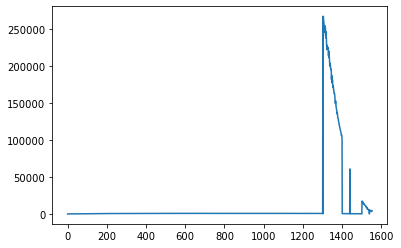

In [71]:
plt.plot(n_inside_on_y_comp)

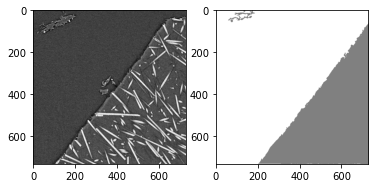

In [77]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(
    voldata[:, 1313, :],
    vmin=0, vmax=255, cmap='gray',
)

axs[1].imshow(
    volmask_complementary[:, 1350, :],
    vmin=0, vmax=2, cmap='gray',
)

In [78]:
inside_indices = np.where(volmask_complementary == 1)
outside_indices = np.where(volmask_complementary == 2)

In [79]:
inside_indices[0].shape

(19017448,)

In [80]:
outside_indices[0].shape

(64109623,)

In [81]:
inside_indices = list(zip(*map(lambda x: x.tolist(), inside_indices)))

In [86]:
outside_indices = list(zip(*map(lambda x: x.tolist(), outside_indices)))

In [83]:
len(inside_indices)

19017448

In [87]:
len(outside_indices)

64109623

In [112]:
position = inside_indices[-10]
position

(733, 1553, 654)

In [127]:
window = 200
dims = volmask_complementary.shape
step = 10

def get_slc(position, window, dims, step):
    return (
        slice(
            max(0, int(position[0] - window/2)), 
            min(dims[0], int(position[0] + window/2)), 
            step
        ),
        slice(position[1], position[1] + 1, None),
        slice(
            max(0, int(position[2] - window/2)), 
            min(dims[2], int(position[2] + window/2)), 
            step
        ),
    )

pos_slc = get_slc(position, window, dims, step)
pos_slc


(slice(633, 734, None), slice(1553, 1554, None), slice(554, 728, None))

In [117]:
patch = volmask_complementary[pos_slc]
patch.shape

(101, 1, 174)

In [121]:
%timeit 100
np.sort(patch.ravel())

8.57 ns ± 0.0552 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


array([1, 1, 1, ..., 2, 2, 2], dtype=uint8)

In [122]:
9e-9 * len(inside_indices)

0.171157032

In [123]:
9e-9 * len(outside_indices)

0.5769866069999999

In [ ]:
inside_indices_sorted_patches = [
    np.sort(volmask_complementary[get_slc(pos, window=200, dims=dims)].ravel())
    for pos in pbar(inside_indices)
]

  0% (142387 of 19017448) |              | Elapsed Time: 0:00:36 ETA:   1:30:08